# READ ME

This is a training pipeline as of 19.06.2025 where we start to include more complex predictive models in our project. First, we introduce the Temporal Fusion Transformer (TFT) and Temporal ConvNet (TCN) models.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Union, Any
import warnings
import random
from Base_models import FeedForwardPredictor, AutoEncoder, ElasticNetLoss
from TM_models import TemporalFusionTransformer, TemporalConvNet
import math

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # might slow down but ensures reproducibility
    torch.backends.cudnn.benchmark = False
    
set_seed()

def calculate_sharpe_ratio(strategy_returns: np.ndarray, rf_rate: float) -> float:
    """Calculate annualized Sharpe ratio using strategy returns and actual risk-free rate"""
    if len(strategy_returns) == 0 or np.std(strategy_returns) == 0:
        return 0.0
    # rf_rate is already annual, convert to daily
    daily_rf = rf_rate / 252  # Assuming daily data
    excess_returns = strategy_returns - daily_rf
    return np.sqrt(252) * np.mean(excess_returns) / np.std(strategy_returns)

def calculate_sortino_ratio(strategy_returns: np.ndarray, rf_rate: float) -> float:
    """Calculate annualized Sortino ratio using strategy returns and actual risk-free rate"""
    if len(strategy_returns) == 0:
        return 0.0
    # rf_rate is already annual, convert to daily
    daily_rf = rf_rate / 252  # Assuming daily data
    excess_returns = strategy_returns - daily_rf
    downside_returns = excess_returns[excess_returns < 0]
    if len(downside_returns) == 0:
        return np.inf
    return np.sqrt(252) * np.mean(excess_returns) / np.std(downside_returns)

def hit_rate(pred: np.ndarray, targ: np.ndarray) -> float:
    """Percentage of months the sign is predicted correctly."""
    return np.mean(np.sign(pred) == np.sign(targ))

def train_autoencoder(X_train: np.ndarray, encoding_dim: int, epochs: int = 100, 
                     lr: float = 0.001, device: str = 'cpu') -> AutoEncoder:
    """Train autoencoder on training data only"""
    input_dim = X_train.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            x_batch = batch[0]
            optimizer.zero_grad()
            reconstructed = autoencoder(x_batch)
            loss = criterion(reconstructed, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    autoencoder.eval()
    return autoencoder

def train_model_epoch(model: nn.Module, dataloader, criterion: nn.Module,
                     optimizer, scheduler=None, model_type: str = 'feedforward', device: str = 'cpu') -> float:
    """Extended training function with gradient clipping for attention models."""
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        
        # Gradient clipping for attention-based models
        if model_type.lower() in ['transformer', 'tft', 'temporal_fusion_transformer']:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        elif model_type.lower() in ['tcn', 'temporal_conv_net']:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.step()
        if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# def evaluate_model(model: nn.Module, dataloader: DataLoader, criterion: nn.Module,
#                   device: str) -> Tuple[float, np.ndarray, np.ndarray]:
#     """Evaluate model and return loss, predictions, and targets"""
#     model.eval()
#     total_loss = 0
#     all_predictions = []
#     all_targets = []
    
#     with torch.no_grad():
#         for X_batch, y_batch in dataloader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             predictions = model(X_batch).squeeze()
#             loss = criterion(predictions, y_batch)
#             total_loss += loss.item()
#             all_predictions.extend(predictions.cpu().numpy())
#             all_targets.extend(y_batch.cpu().numpy())
    
#     return total_loss / len(dataloader), np.array(all_predictions), np.array(all_targets)

def evaluate_model(model: nn.Module,
                   dataloader: DataLoader,
                   criterion: nn.Module,
                   device: str) -> Tuple[float, np.ndarray, np.ndarray]:

    model.eval()
    total_loss = 0.0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # ── 1. keep the batch axis ───────────────────────────────
            predictions = model(X_batch).squeeze(-1)      # shape: (batch_size,)
            y_batch     = y_batch.squeeze(-1)             # same for targets

            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # ── 2. flatten before extending the lists ───────────────
            all_predictions.extend(predictions.cpu().numpy().ravel())
            all_targets.extend(y_batch.cpu().numpy().ravel())

    avg_loss = total_loss / len(dataloader)
    return avg_loss, np.array(all_predictions), np.array(all_targets)

def get_optimizer_for_model(model: nn.Module, model_type: str, lr: float = 0.001):
    """Extended optimizer function supporting new model types."""
    if model_type.lower() in ['transformer', 'tft', 'temporal_fusion_transformer']:
        # AdamW often works better for attention-based models
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, betas=(0.9, 0.999))
    elif model_type.lower() in ['tcn', 'temporal_conv_net']:
        # Adam with slightly different settings for CNNs
        return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    else:
        # Standard Adam for other models
        return torch.optim.Adam(model.parameters(), lr=lr)

def get_learning_rate_scheduler(optimizer, model_type: str, num_training_steps: int = None):
    """Extended scheduler function supporting new model types."""
    if model_type.lower() in ['transformer', 'tft', 'temporal_fusion_transformer'] and num_training_steps:
        # Warmup scheduler for attention-based models
        return torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=optimizer.param_groups[0]['lr'] * 10,
            total_steps=num_training_steps,
            pct_start=0.1  # 10% warmup
        )
    elif model_type.lower() in ['tcn', 'temporal_conv_net']:
        # Cosine annealing for TCN
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    else:
        # Simple step scheduler for other models
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

def prepare_data_for_model(X: np.ndarray, y: np.ndarray, model_type: str, 
                          seq_length: int = 12, ar_lags: int = 5) -> Tuple[torch.Tensor, torch.Tensor]:
    """Prepare data based on model type with autoregressive returns component - FIXED VERSION"""
    # Fix 1: Updated the model type checks to include all new models
    if model_type.lower() in ['lstm', 'transformer', 'tcn', 'temporal_conv_net', 'tft', 'temporal_fusion_transformer']:
        # For sequence models, create sequences of features AND autoregressive returns
        X_seq, y_seq = [], []
        for i in range(max(seq_length, ar_lags), len(X)):
            # Get feature sequence
            feature_seq = X[i-seq_length:i]
            
            # Get autoregressive returns (lagged returns)
            ar_returns = y[i-ar_lags:i].reshape(-1, 1)  # Previous ar_lags returns
            
            # For sequence models, we need to add AR returns to each time step
            # We'll append AR returns to the last time step of the sequence
            # Pad AR returns to match sequence length
            ar_padded = np.zeros((seq_length, ar_lags))
            ar_padded[-1, :] = ar_returns.flatten()  # Add AR returns to last time step
            
            # Concatenate features with AR returns
            combined_seq = np.concatenate([feature_seq, ar_padded], axis=1)
            
            X_seq.append(combined_seq)
            y_seq.append(y[i])
        
        return torch.FloatTensor(np.array(X_seq)), torch.FloatTensor(np.array(y_seq))
    else:
        # For feedforward, use current features + autoregressive returns
        X_ar, y_ar = [], []
        for i in range(ar_lags, len(X)):
            # Current features
            current_features = X[i]
            
            # Autoregressive returns (previous ar_lags returns)
            ar_returns = y[i-ar_lags:i]
            
            # Combine features with AR returns
            combined_features = np.concatenate([current_features, ar_returns])
            
            X_ar.append(combined_features)
            y_ar.append(y[i])
        
        return torch.FloatTensor(np.array(X_ar)), torch.FloatTensor(np.array(y_ar))

def get_input_dim_for_model(X_tensor, model_type: str):
    """Get correct input dimension based on model type and tensor shape."""
    if model_type.lower() in ['lstm', 'transformer', 'tcn', 'temporal_conv_net', 'tft', 'temporal_fusion_transformer']:
        return X_tensor.shape[-1]  # Features + AR lags for sequence models
    else:
        return X_tensor.shape[-1]  # Features + AR lags for feedforward models
    
def sp500_training_pipeline(
    X: np.ndarray,
    y: np.ndarray,
    dates: pd.DatetimeIndex,
    tbill3m: np.ndarray,  # Risk-free rates
    model_class: type,
    model_kwargs: Dict[str, Any],
    model_type: str = 'feedforward',  # 'feedforward' or 'lstm'
    window_strategy: str = 'rolling',  # 'rolling' or 'expanding'
    train_window_years: int = 3,
    test_window_years: int = 1,
    use_autoencoder: bool = True,
    encoding_dim: int = 10,
    walk_forward_cv: bool = False,
    cv_months: int = 2,
    seq_length: int = 12,  # For LSTM models
    ar_lags: int = 5,  # Number of autoregressive lags to include
    epochs: int = 100,
    lr: float = 0.001,
    batch_size: int = 32,
    alpha = 0.1,  # ElasticNet alpha
    l1_ratio = 0.5,  # ElasticNet l1_ratio
    device: str = 'cpu',
    random_seed: int = 42,
    plot_results: bool = True
) -> Dict[str, Any]:
    """
    Comprehensive S&P 500 returns prediction pipeline with rolling/expanding windows.
    Now includes autoregressive returns component.
    """
    
    # Set random seeds for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    # Convert dates to pandas DatetimeIndex if not already
    if not isinstance(dates, pd.DatetimeIndex):
        dates = pd.DatetimeIndex(dates)
    
    # Initialize storage
    results = {
        'fold_results': [],
        'scalers': [],
        'autoencoders': [],
        'models': [],
        'all_train_predictions': [],
        'all_train_targets': [],
        'all_test_predictions': [],
        'all_test_targets': [],
        'all_train_dates': [],
        'all_test_dates': [],
        'metrics': {
            'train_mse': [],
            'test_mse': [],
            'train_sharpe': [],
            'test_sharpe': [],
            'train_mae': [], 'test_mae': [],
            'train_r2':  [], 'test_r2':  [],
            'train_sortino': [], 'test_sortino': [],
            'train_hit': [], 'test_hit': []
        }
    }
    
    # Create date-based windows
    start_date = dates[0]
    end_date = dates[-1]
    
    # Calculate fold start dates
    fold_start_dates = []
    current_date = start_date + pd.DateOffset(years=train_window_years)
    
    while current_date + pd.DateOffset(years=test_window_years) <= end_date:
        fold_start_dates.append(current_date)
        current_date += pd.DateOffset(years=test_window_years)
    
    n_folds = len(fold_start_dates)
    
    print(f"Starting {window_strategy} window training with {n_folds} folds")
    print(f"Train window: {train_window_years} years, Test window: {test_window_years} years")
    print(f"Data period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Using {ar_lags} autoregressive lags")
    
    fold_predictions = []
    fold_targets = []
    fold_dates = []
    
    for fold_idx, test_start_date in enumerate(fold_start_dates):
        print(f"\n--- Fold {fold_idx + 1}/{n_folds} ---")
        
        # Define test period
        test_end_date = test_start_date + pd.DateOffset(years=test_window_years)
        
        # Define train period based on strategy
        if window_strategy == 'rolling':
            train_start_date = test_start_date - pd.DateOffset(years=train_window_years)
        else:  # expanding
            train_start_date = start_date
        
        train_end_date = test_start_date
        
        # Get indices for train and test periods
        train_mask = (dates >= train_start_date) & (dates < train_end_date)
        test_mask = (dates >= test_start_date) & (dates < test_end_date)
        
        # Check if we have enough data
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            print(f"Skipping fold {fold_idx + 1}: insufficient data")
            continue
        
        # Extract data
        train_indices = np.where(train_mask)[0]
        test_indices = np.where(test_mask)[0]
        X_train = X[train_mask]
        X_test  = X[test_mask]
        y_train = y[train_mask]
        y_test  = y[test_mask]
        
        train_dates = dates[train_indices]
        test_dates = dates[test_indices]
        
        print(f"Train period: {train_dates[0].strftime('%Y-%m-%d')} to {train_dates[-1].strftime('%Y-%m-%d')} ({len(train_dates)} days)")
        print(f"Test period: {test_dates[0].strftime('%Y-%m-%d')} to {test_dates[-1].strftime('%Y-%m-%d')} ({len(test_dates)} days)")
        
        # Feature standardization (fit only on training data, exclude returns)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Autoencoder training and encoding (if enabled) - only on features, not returns
        autoencoder = None
        if use_autoencoder:
            print(f"Training autoencoder with encoding dimension {encoding_dim}")
            autoencoder = train_autoencoder(X_train_scaled, encoding_dim, 
                                          epochs=50, lr=lr, device=device)
            
            # Encode features
            with torch.no_grad():
                X_train_encoded = autoencoder.encode(torch.FloatTensor(X_train_scaled).to(device)).cpu().numpy()
                X_test_encoded = autoencoder.encode(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
        else:
            X_train_encoded = X_train_scaled
            X_test_encoded = X_test_scaled
        
        # Prepare data for model type WITH autoregressive returns
        X_train_tensor, y_train_tensor = prepare_data_for_model(X_train_encoded, y_train, 
                                                              model_type, seq_length, ar_lags)
        X_test_tensor, y_test_tensor = prepare_data_for_model(X_test_encoded, y_test, 
                                                            model_type, seq_length, ar_lags)
        
        # Adjust dates for sequence models or AR lags
        data_start_offset = max(seq_length, ar_lags) if model_type.lower() in ['lstm', 'transformer'] else ar_lags
        train_dates_adj = train_dates[data_start_offset:]
        test_dates_adj = test_dates[data_start_offset:]
        
        # Walk-forward cross-validation (optional) - modified for daily data
        best_model_state = None
        if walk_forward_cv and len(X_train_tensor) > cv_months * 20:  # Approximate days per month
            print(f"Performing walk-forward CV with {cv_months} months validation")
            
            # Split training data for CV - use approximate days
            cv_days = cv_months * 20  # Rough approximation
            cv_split = len(X_train_tensor) - cv_days
            X_train_cv = X_train_tensor[:cv_split]
            y_train_cv = y_train_tensor[:cv_split]
            X_val_cv = X_train_tensor[cv_split:]
            y_val_cv = y_train_tensor[cv_split:]
            
            # Initialize model for CV - input_dim now includes AR lags
            if model_type.lower() in ['lstm', 'transformer','tcn', 'temporal_conv_net', 'tft', 'temporal_fusion_transformer']:
                input_dim = X_train_tensor.shape[-1]  # Features + AR lags
            else:
                input_dim = X_train_tensor.shape[-1]  # Features + AR lags
            
            model = model_class(input_dim=input_dim, **model_kwargs).to(device)
            criterion = nn.MSELoss()
            optimizer = get_optimizer_for_model(model, model_type, lr)
            num_training_steps = (len(X_train_cv) // batch_size) * epochs
            scheduler = get_learning_rate_scheduler(optimizer, model_type, num_training_steps=num_training_steps)
            
            # Create data loaders for CV
            train_cv_dataset = TensorDataset(X_train_cv, y_train_cv)
            train_cv_loader = DataLoader(train_cv_dataset, batch_size=batch_size, shuffle=True)
            val_cv_dataset = TensorDataset(X_val_cv, y_val_cv)
            val_cv_loader = DataLoader(val_cv_dataset, batch_size=batch_size, shuffle=False)
            
            best_val_loss = float('inf')
            patience = 10
            patience_counter = 0
            
            for epoch in range(epochs):
                train_loss = train_model_epoch(model, train_cv_loader, criterion, optimizer, device)
                val_loss, _, _ = evaluate_model(model, val_cv_loader, criterion, device)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch + 1}")
                        break
        
        # Final model training on full training set
        if model_type.lower() in ['lstm', 'transformer','tcn', 'temporal_conv_net', 'tft', 'temporal_fusion_transformer']:
            input_dim = X_train_tensor.shape[-1]  # Features + AR lags
        else:
            input_dim = X_train_tensor.shape[-1]  # Features + AR lags
            
        model = model_class(input_dim=input_dim, **model_kwargs).to(device)
        
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        criterion = ElasticNetLoss(model=model, alpha=alpha, l1_ratio=l1_ratio)
        optimizer = get_optimizer_for_model(model, model_type, lr)
        num_training_steps = (len(X_train_tensor) // batch_size) * epochs
        scheduler = get_learning_rate_scheduler(optimizer, model_type, num_training_steps=None)
        
        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Final training
        print("Training final model...")
        final_epochs = epochs // 2 if walk_forward_cv else epochs
        for epoch in range(final_epochs):
            train_loss = train_model_epoch(model, train_loader, criterion, optimizer, scheduler=scheduler, model_type=model_type, device=device)
            if (epoch + 1) % 20 == 0 or ((epoch + 1) % 5 == 0 and model_type.lower() in ['tft', 'temporal_fusion_transformer','tcn', 'temporal_conv_net']):
                print(f"Epoch {epoch + 1}/{final_epochs}, Loss: {train_loss:.6f}")
        
        # Evaluate on both train and test sets
        train_loss, train_predictions, train_targets = evaluate_model(model, train_loader, criterion, device)
        test_loss, test_predictions, test_targets = evaluate_model(model, test_loader, criterion, device)
        
        # Calculate metrics
        train_mse = mean_squared_error(train_targets, train_predictions)
        test_mse = mean_squared_error(test_targets, test_predictions)

        train_mae   = mean_absolute_error(train_targets, train_predictions)
        test_mae    = mean_absolute_error(test_targets,  test_predictions)

        train_r2    = r2_score(train_targets, train_predictions)
        test_r2     = r2_score(test_targets,  test_predictions)

        train_positions = np.sign(train_predictions)
        test_positions = np.sign(test_predictions)
        train_strategy_returns = train_positions * train_targets
        test_strategy_returns = test_positions * test_targets
        
        # Get average risk-free rate for the periods
        train_rf = np.mean(tbill3m[train_mask])
        test_rf = np.mean(tbill3m[test_mask])
        
        train_sharpe = calculate_sharpe_ratio(train_strategy_returns, train_rf)
        test_sharpe = calculate_sharpe_ratio(test_strategy_returns, test_rf)
        train_sortino = calculate_sortino_ratio(train_strategy_returns, train_rf)
        test_sortino = calculate_sortino_ratio(test_strategy_returns, test_rf)

        train_hit     = hit_rate(train_predictions, train_targets)
        test_hit      = hit_rate(test_predictions,  test_targets)
        
        print(f"Train MSE {train_mse:.6f} | MAE {train_mae:.6f} | R² {train_r2:.4f} | Sharpe {train_sharpe:.3f} | Sortino {train_sortino:.3f} | Hit {train_hit:.2%}")
        print(f"Test  MSE {test_mse:.6f} | MAE {test_mae:.6f} | R² {test_r2:.4f} | Sharpe {test_sharpe:.3f} | Sortino {test_sortino:.3f} | Hit {test_hit:.2%}")

        # Store results - everything below remains the same
        fold_result = {
            'fold': fold_idx,
            'train_period': (train_dates[0], train_dates[-1]),
            'test_period': (test_dates[0], test_dates[-1]),
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_sharpe': train_sharpe,
            'test_sharpe': test_sharpe,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_sortino': train_sortino,
            'test_sortino': test_sortino,
            'train_hit': train_hit,
            'test_hit': test_hit,
            'train_predictions': train_predictions,
            'test_predictions': test_predictions,
            'train_targets': train_targets,
            'test_targets': test_targets,
            'train_dates': train_dates_adj,
            'test_dates': test_dates_adj
        }
        
        results['fold_results'].append(fold_result)
        results['scalers'].append(scaler)
        results['autoencoders'].append(autoencoder)
        results['models'].append(model.state_dict())
        
        # Accumulate for overall plotting
        results['all_train_predictions'].extend(train_predictions)
        results['all_train_targets'].extend(train_targets)
        results['all_test_predictions'].extend(test_predictions)
        results['all_test_targets'].extend(test_targets)
        results['all_train_dates'].extend(train_dates_adj)
        results['all_test_dates'].extend(test_dates_adj)
        
        results['metrics']['train_mse'].append(train_mse)
        results['metrics']['test_mse'].append(test_mse)
        results['metrics']['train_sharpe'].append(train_sharpe)
        results['metrics']['test_sharpe'].append(test_sharpe)
        results['metrics']['train_mae'].append(train_mae)
        results['metrics']['test_mae'].append(test_mae)
        results['metrics']['train_r2'].append(train_r2)
        results['metrics']['test_r2'].append(test_r2)
        results['metrics']['train_sortino'].append(train_sortino)
        results['metrics']['test_sortino'].append(test_sortino)
        results['metrics']['train_hit'].append(train_hit)
        results['metrics']['test_hit'].append(test_hit)
        
        # Store for individual fold plotting
        fold_predictions.append((train_predictions, test_predictions))
        fold_targets.append((train_targets, test_targets))
        fold_dates.append((train_dates_adj, test_dates_adj))
    
    # Calculate overall metrics
    if results['metrics']['train_mse']:
        results['overall_metrics'] = {
            'avg_train_mse': np.mean(results['metrics']['train_mse']),
            'avg_test_mse': np.mean(results['metrics']['test_mse']),
            'avg_train_sharpe': np.mean(results['metrics']['train_sharpe']),
            'avg_test_sharpe': np.mean(results['metrics']['test_sharpe']),
            'std_train_mse': np.std(results['metrics']['train_mse']),
            'std_test_mse': np.std(results['metrics']['test_mse']),
            'std_train_sharpe': np.std(results['metrics']['train_sharpe']),
            'std_test_sharpe': np.std(results['metrics']['test_sharpe']),
            'avg_train_mae': np.mean(results['metrics']['train_mae']),
            'avg_test_mae': np.mean(results['metrics']['test_mae']),
            'std_train_mae': np.std(results['metrics']['train_mae']),
            'std_test_mae': np.std(results['metrics']['test_mae']),
            'avg_train_r2': np.mean(results['metrics']['train_r2']),
            'avg_test_r2': np.mean(results['metrics']['test_r2']),
            'std_train_r2': np.std(results['metrics']['train_r2']),
            'std_test_r2': np.std(results['metrics']['test_r2']),
            'avg_train_sortino': np.mean(results['metrics']['train_sortino']),
            'avg_test_sortino': np.mean(results['metrics']['test_sortino']),
            'std_train_sortino': np.std(results['metrics']['train_sortino']),
            'std_test_sortino': np.std(results['metrics']['test_sortino']),
            'avg_train_hit': np.mean(results['metrics']['train_hit']),
            'avg_test_hit': np.mean(results['metrics']['test_hit']),
            'std_train_hit': np.std(results['metrics']['train_hit']),
            'std_test_hit': np.std(results['metrics']['test_hit'])
        }
        
        print("\n=== OVERALL RESULTS ===")
        print(f"Average Train MSE: {results['overall_metrics']['avg_train_mse']:.6f} ± {results['overall_metrics']['std_train_mse']:.6f}")
        print(f"Average Test MSE: {results['overall_metrics']['avg_test_mse']:.6f} ± {results['overall_metrics']['std_test_mse']:.6f}")
        print(f"Average Train Sharpe: {results['overall_metrics']['avg_train_sharpe']:.4f} ± {results['overall_metrics']['std_train_sharpe']:.4f}")
        print(f"Average Test Sharpe: {results['overall_metrics']['avg_test_sharpe']:.4f} ± {results['overall_metrics']['std_test_sharpe']:.4f}")
        print(f"Average Train MAE: {results['overall_metrics']['avg_train_mae']:.6f} ± {results['overall_metrics']['std_train_mae']:.6f}")
        print(f"Average Test MAE: {results['overall_metrics']['avg_test_mae']:.6f} ± {results['overall_metrics']['std_test_mae']:.6f}")
        print(f"Average Train R²: {results['overall_metrics']['avg_train_r2']:.4f} ± {results['overall_metrics']['std_train_r2']:.4f}")
        print(f"Average Test R²: {results['overall_metrics']['avg_test_r2']:.4f} ± {results['overall_metrics']['std_test_r2']:.4f}")
        print(f"Average Train Sortino: {results['overall_metrics']['avg_train_sortino']:.4f} ± {results['overall_metrics']['std_train_sortino']:.4f}") 
        print(f"Average Test Sortino: {results['overall_metrics']['avg_test_sortino']:.4f} ± {results['overall_metrics']['std_test_sortino']:.4f}")
        print(f"Average Train Hit Rate: {results['overall_metrics']['avg_train_hit']:.2%} ± {results['overall_metrics']['std_train_hit']:.2%}")
        print(f"Average Test Hit Rate: {results['overall_metrics']['avg_test_hit']:.2%} ± {results['overall_metrics']['std_test_hit']:.2%}")

    
    # Plotting
    if plot_results and fold_predictions:
        n_plots = len(fold_predictions)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots))
        if n_plots == 1:
            axes = [axes]
        
        for i, (fold_pred, fold_targ, fold_date) in enumerate(zip(fold_predictions, fold_targets, fold_dates)):
            train_pred, test_pred = fold_pred
            train_targ, test_targ = fold_targ
            train_date, test_date = fold_date
            
            ax = axes[i]
            # Plot actual returns (always black)

            ax.plot(train_date, train_targ, 'k-', label='Actual Returns', linewidth=1)
            ax.plot(test_date, test_targ, 'k-', linewidth=1)
            
            # Plot predictions (blue for train, red for test)
            ax.plot(train_date, train_pred, 'b-', label='Train Predictions', alpha=0.7)
            ax.plot(test_date, test_pred, 'r-', label='Test Predictions', alpha=0.7)
            
            # Add vertical line to separate train/test
            if len(test_date) > 0:
                ax.axvline(x=test_date[0], color='gray', linestyle='--', alpha=0.5)
            
            ax.set_title(f'Fold {i+1}: Predictions vs Actual Returns')
            ax.set_ylabel('Returns')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Overall performance plot
        if len(results['all_train_dates']) > 0:
            plt.figure(figsize=(15, 6))
            
            # Combine and sort all data by date
            all_data = []
            for train_pred, train_targ, train_date in zip(
                [results['fold_results'][i]['train_predictions'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['train_targets'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['train_dates'] for i in range(len(results['fold_results']))]
            ):
                for pred, targ, date in zip(train_pred, train_targ, train_date):
                    all_data.append((date, targ, pred, 'train'))
            
            for test_pred, test_targ, test_date in zip(
                [results['fold_results'][i]['test_predictions'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['test_targets'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['test_dates'] for i in range(len(results['fold_results']))]
            ):
                for pred, targ, date in zip(test_pred, test_targ, test_date):
                    all_data.append((date, targ, pred, 'test'))
            
            # Sort by date
            all_data.sort(key=lambda x: x[0])
            
            # Separate data
            dates_all = [x[0] for x in all_data]
            targets_all = [x[1] for x in all_data]
            predictions_all = [x[2] for x in all_data]
            types_all = [x[3] for x in all_data]
            
            # Plot
            plt.plot(dates_all, targets_all, 'k-', label='Actual Returns', linewidth=1)
            
            # Plot predictions with different colors
            train_mask = np.array(types_all) == 'train'
            test_mask = np.array(types_all) == 'test'
            
            if np.any(train_mask):
                plt.plot(np.array(dates_all)[train_mask], np.array(predictions_all)[train_mask], 
                        'b.', label='Train Predictions', alpha=0.7, markersize=3)
            if np.any(test_mask):
                plt.plot(np.array(dates_all)[test_mask], np.array(predictions_all)[test_mask], 
                        'r.', label='Test Predictions', alpha=0.7, markersize=3)
            
            plt.title('Overall Model Performance: Predictions vs Actual Returns')
            plt.ylabel('Returns')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    return results

In [27]:
df= pd.read_csv("data_non_std.csv",parse_dates=["Unnamed: 0"]).rename(columns={'Unnamed: 0': 'Date'}) 
features = df.drop(columns=["returns", "Date"])
target = df["returns"].values.astype(np.float32)
dates = pd.to_datetime(df["Date"]).astype('datetime64[ns]').tolist()


Starting rolling window training with 13 folds
Train window: 3 years, Test window: 1 years
Data period: 2009-02-23 to 2025-06-13
Using 5 autoregressive lags

--- Fold 1/13 ---
Train period: 2009-02-23 to 2012-02-22 (757 days)
Test period: 2012-02-23 to 2013-02-22 (251 days)
Training autoencoder with encoding dimension 10
Training final model...
Epoch 20/80, Loss: 0.039673
Epoch 40/80, Loss: 0.038987
Epoch 60/80, Loss: 0.039329
Epoch 80/80, Loss: 0.039330
Train MSE 0.000186 | MAE 0.009464 | R² -0.0002 | Sharpe 0.568 | Sortino 0.765 | Hit 56.78%
Test  MSE 0.000067 | MAE 0.006099 | R² -0.0057 | Sharpe 0.195 | Sortino 0.302 | Hit 51.63%

--- Fold 2/13 ---
Train period: 2010-02-23 to 2013-02-22 (756 days)
Test period: 2013-02-25 to 2014-02-21 (251 days)
Training autoencoder with encoding dimension 10
Training final model...
Epoch 20/80, Loss: 0.040746
Epoch 40/80, Loss: 0.039860
Epoch 60/80, Loss: 0.040266
Epoch 80/80, Loss: 0.040379
Train MSE 0.000133 | MAE 0.007887 | R² -0.0000 | Sharpe 0

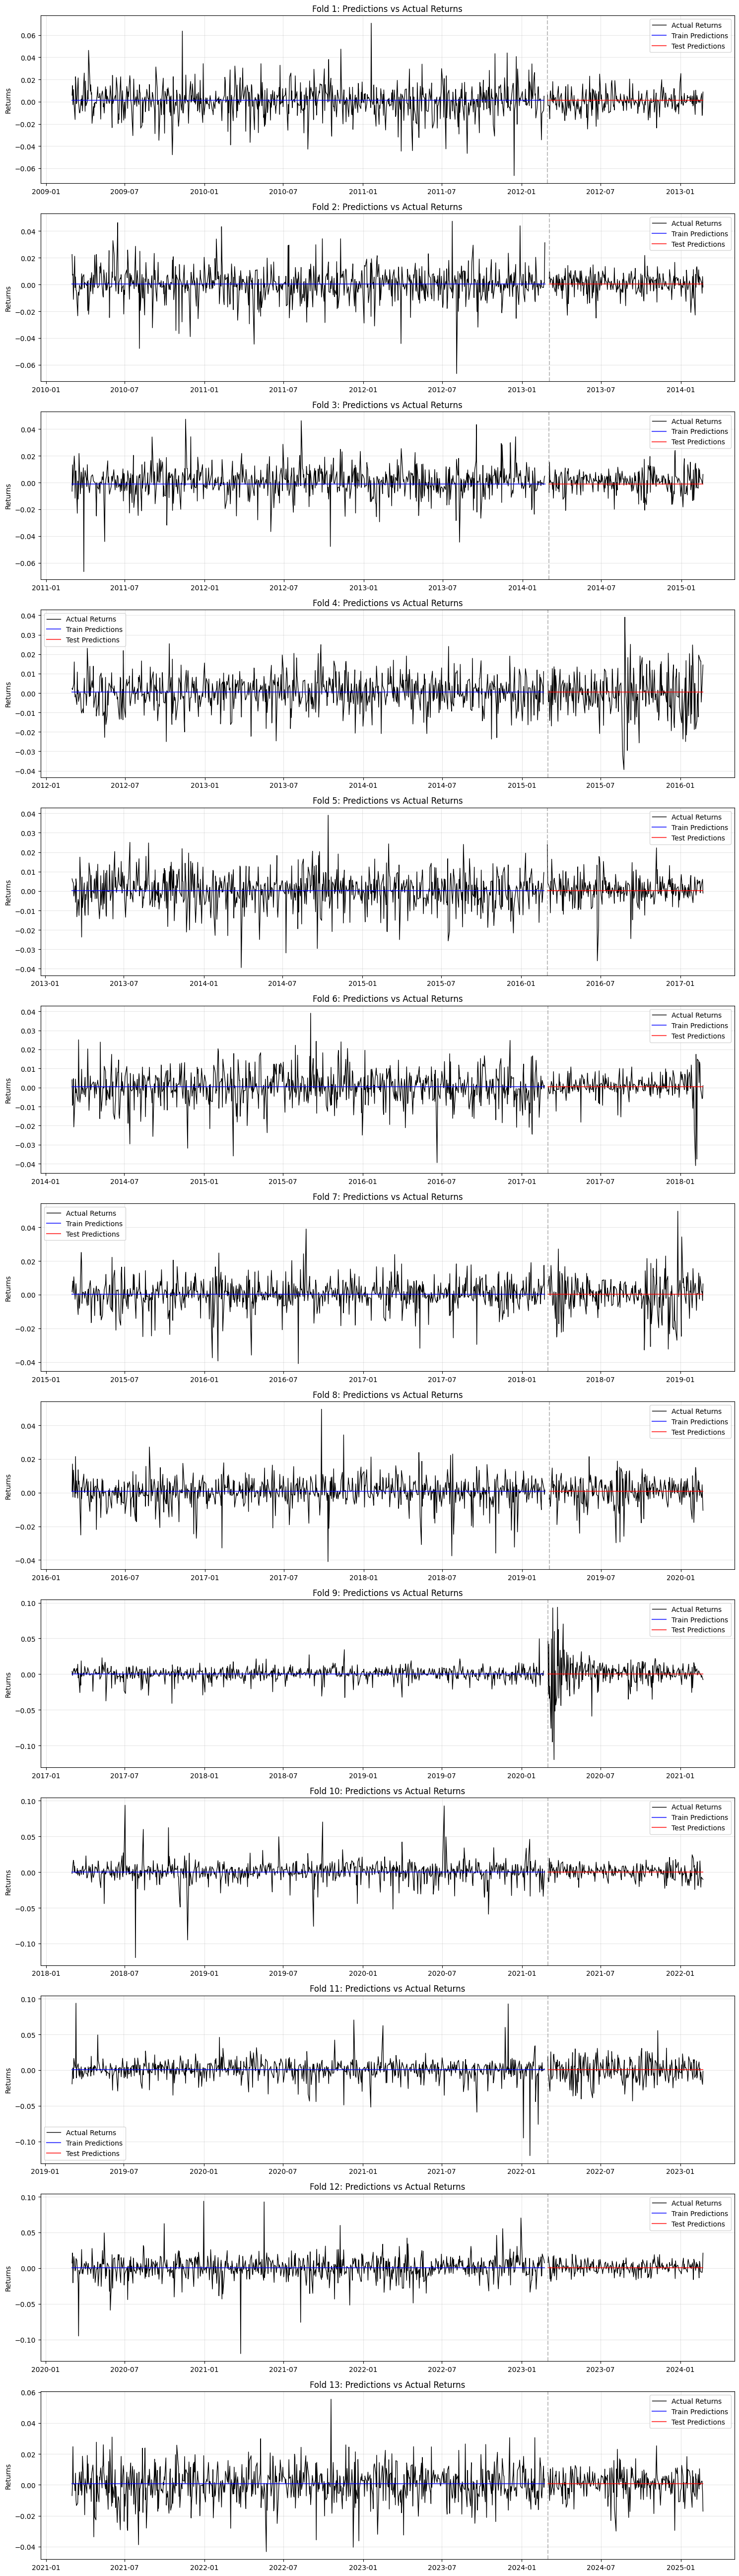

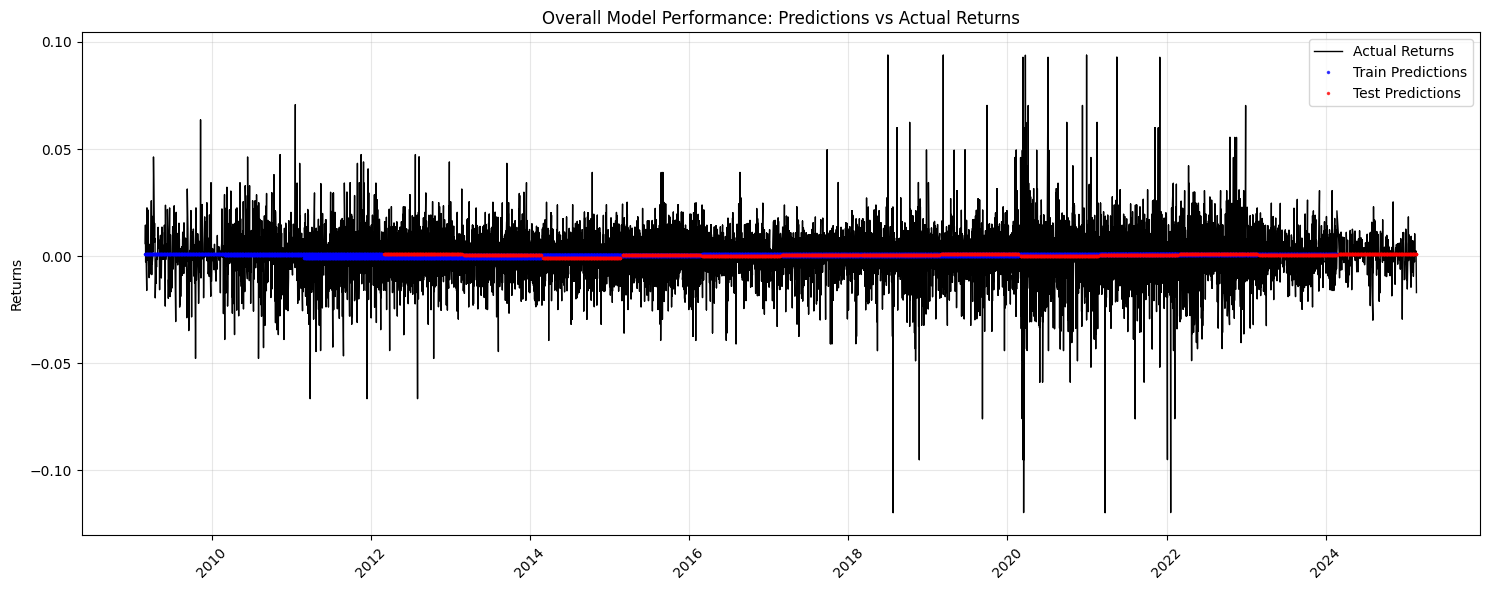

In [28]:
class SimpleFeedForward(nn.Module):
    """Example feedforward model"""
    def __init__(self, input_dim, hidden_dim=200, dropout=0):
        super(SimpleFeedForward, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        return self.network(x)
    
class SimpleLSTM(nn.Module):
    """Example LSTM model"""
    def __init__(self, input_dim, hidden_dim=200, num_layers=2, dropout=0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(hidden_dim // 2, 1))
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use last time step output

class SimpleTransformer(nn.Module):
    def __init__(self,
                 input_dim: int,
                 model_dim: int = 128,   # divisible by nhead
                 nhead: int = 8,
                 num_layers: int = 2,
                 dropout: float = 0.1,
                 max_seq_length: int = 500):  # for positional encoding
        super().__init__()

        # project raw features to model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Add positional encoding 
        self.pos_encoding = PositionalEncoding(model_dim, dropout, max_seq_length)

        # vanilla encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=nhead,
                dim_feedforward=model_dim * 4,  # standard practice
                dropout=dropout,
                activation='gelu',  # often works better than relu for transformers
                batch_first=True        # so x is (B, T, F)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # regression head with additional processing
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(model_dim, 1)

    def forward(self, x):               # x: (B, T, input_dim)
        x = self.input_proj(x)          # (B, T, model_dim)
        x = self.pos_encoding(x)        # Add positional information
        x = self.encoder(x)             # (B, T, model_dim)
        x = self.norm(x[:, -1])         # Layer norm on last time step
        x = self.dropout(x)             # Additional dropout
        return self.fc(x)               # (B, 1)


class PositionalEncoding(nn.Module):
    """Add positional encoding to input embeddings."""
    
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)
    
tbill3m_data = df["tbill3m"].values.astype(np.float32)

results_tcn = sp500_training_pipeline(
    X=features,
    y=target,
    dates=dates,
    tbill3m=tbill3m_data,
    model_class=SimpleFeedForward,
    model_kwargs={
        'hidden_dim': 100,  # Adjusted for TCN
        'dropout': 0.1
    },
    model_type='feedforward',  
    window_strategy='rolling',
    train_window_years=3,
    test_window_years=1,
    use_autoencoder=True,
    encoding_dim=10,
    ar_lags=5,
    epochs=80,
    lr=0.001,
    plot_results=True
)
    

In [29]:
results_tft = sp500_training_pipeline(
    X=features,
    y=target,
    dates=dates,
    tbill3m=tbill3m_data,
    model_class=TemporalFusionTransformer,
    model_kwargs={
        'hidden_dim': 128,
        'num_heads': 8,
        'num_layers': 2,
        'dropout': 0.1
    },
    model_type='tft',  # Use 'tft' as model_type
    window_strategy='rolling',
    train_window_years=3,
    test_window_years=1,
    use_autoencoder=True,
    encoding_dim=15,  # TFT can handle more complex features
    seq_length=18,
    ar_lags=5,
    epochs=80,
    lr=0.0005,  # Lower learning rate for TFT
    plot_results=True
)

Starting rolling window training with 13 folds
Train window: 3 years, Test window: 1 years
Data period: 2009-02-23 to 2025-06-13
Using 5 autoregressive lags

--- Fold 1/13 ---
Train period: 2009-02-23 to 2012-02-22 (757 days)
Test period: 2012-02-23 to 2013-02-22 (251 days)
Training autoencoder with encoding dimension 15
Training final model...
Epoch 5/80, Loss: 147.537631


KeyboardInterrupt: 